<img align="center" style="max-width: 900px; height: auto" src="../assets/banner.png">

###  Coding Challenge Template - EuroSAT Classification

<img align="right" style="max-width: 200px; height: auto" src="../assets/hsg_logo.png">
<img align="center" style="max-width: 300px; height: auto" src="./sentinel2.jpg">

7,854,1.00 MCS Machine Learning, University of St.Gallen (HSG)

**Task**: Create a model to predict the most likely EuroSAT class for each image of the testset.

**Approach**: Build a complete machine learning pipeline including data loading, preprocessing, model architecture, training, and evaluation.

### Objectives:
- Create a dataset class and data-loader for training
- Design and implement a suitable model architecture
- Address the potential domain shift between train and test data
- Train and evaluate the model performance
- Generate predictions for the test set

## 1. Import Libraries and Setup

In [56]:
# Basic libraries
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

# Raster data handling
import rasterio as rio
from rasterio.plot import reshape_as_image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Utilities
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 2. Configuration and Constants

In [57]:
# Configuration
CONFIG = {
    'eurosat_dir': '/Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/EuroSAT_MS',  # Correct absolute path
    'batch_size': 32,
    'num_epochs': 1,
    'learning_rate': 0.001,
    'validation_split': 0.2,
    'num_workers': 0,  # Set to 0 for notebook compatibility
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# EuroSAT classes
CLASSES = [
    "AnnualCrop",
    "Forest", 
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for idx, cls in enumerate(CLASSES)}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Using device: {CONFIG['device']}")

Number of classes: 10
Using device: cpu


## 3. Data Utilities

In [58]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands for visualization."""
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    
    return (band_data - lower_perc) / (upper_perc - lower_perc)

def normalize_for_model(band_data):
    """Normalize multi-spectral imagery for model training.
    
    Uses per-band standardization (z-score normalization) to handle
    the different value ranges across spectral bands.
    """
    band_data = band_data.astype(np.float32)
    
    # Per-band standardization
    # Calculate mean and std for each band
    band_means = np.mean(band_data, axis=(0, 1), keepdims=True)
    band_stds = np.std(band_data, axis=(0, 1), keepdims=True)
    
    # Avoid division by zero
    band_stds = np.where(band_stds == 0, 1.0, band_stds)
    
    # Normalize
    normalized = (band_data - band_means) / band_stds
    
    return normalized

def visualize_sample(img_data, title="Sample", figsize=(10, 5)):
    """Visualize a multi-spectral sample."""
    normalized_img = normalize_for_display(img_data)
    rgb_img = normalized_img[:, :, [3, 2, 1]]  # RGB bands for Sentinel-2
    
    # Calculate NDVI
    b8 = img_data[:, :, 7]  # Near-infrared
    b4 = img_data[:, :, 3]  # Red
    ndvi = (b8 - b4) / (b8 + b4 + 1e-8)  # Add small epsilon to avoid division by zero
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.imshow(rgb_img)
    ax1.set_title(f"{title} - RGB")
    ax1.axis('off')
    
    ax2.imshow(ndvi, cmap='RdYlGn')
    ax2.set_title(f"{title} - NDVI")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

## 4. Dataset Class

In [59]:
class EuroSATDataset(Dataset):
    """Custom Dataset for EuroSAT satellite imagery."""
    
    def __init__(self, file_paths, labels=None, transform=None, is_test=False):
        """
        Args:
            file_paths: List of file paths to images
            labels: List of labels (None for test set)
            transform: Optional transform to be applied on a sample
            is_test: Boolean indicating if this is test data
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        
        # Load data based on file type
        if file_path.endswith('.npy'):
            # Test data (.npy files)
            img = np.load(file_path)
        else:
            # Training data (.tif files)
            with rio.open(file_path, "r") as f:
                img = f.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
                img = reshape_as_image(img)
        
        # Normalize for model input
        img = normalize_for_model(img)
        
        # Convert to tensor and rearrange dimensions (H, W, C) -> (C, H, W)
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        # Apply transforms if provided
        if self.transform:
            img = self.transform(img)
            
        if self.is_test:
            return img, file_path
        else:
            label = self.labels[idx]
            return img, label

# Implement data augmentation transforms for better generalization
def add_noise(x):
    return x + torch.randn_like(x) * 0.01

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Lambda(add_noise),
])

val_transforms = transforms.Compose([
    # No augmentation for validation, just keep as is
    # If normalization is needed, add here
    # transforms.Normalize(mean, std)
    # For now, pass-through
])

## 5. Data Loading and Exploration

In [60]:
# Load training data file paths and labels based on folder structure
train_samples = []
train_labels = []

for class_name in CLASSES:
    class_folder = os.path.join(CONFIG['eurosat_dir'], class_name)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found for class {class_name}: {class_folder}")
        continue
    # Get all .tif files in this class folder
    tif_files = glob.glob(os.path.join(class_folder, '*.tif'))
    train_samples.extend(tif_files)
    train_labels.extend([CLASS_TO_IDX[class_name]] * len(tif_files))

print(f"Found {len(train_samples)} training samples")
print(f"Number of training samples: {len(train_samples)}")
print(f"Label distribution:")
label_counts = pd.Series(train_labels).value_counts().sort_index()
for idx, count in label_counts.items():
    print(f"  {IDX_TO_CLASS[idx]}: {count}")

Found 27000 training samples
Number of training samples: 27000
Label distribution:
  AnnualCrop: 3000
  Forest: 3000
  HerbaceousVegetation: 3000
  Highway: 2500
  Industrial: 2500
  Pasture: 2000
  PermanentCrop: 2500
  Residential: 3000
  River: 2500
  SeaLake: 3000


In [61]:
# Load test data
testset_dir = os.path.join(CONFIG['eurosat_dir'], "testset")
test_samples = glob.glob(os.path.join(testset_dir, "*.npy"))
print(f"Found {len(test_samples)} test samples")

# Sort test samples for consistent ordering
test_samples.sort()

Found 0 test samples


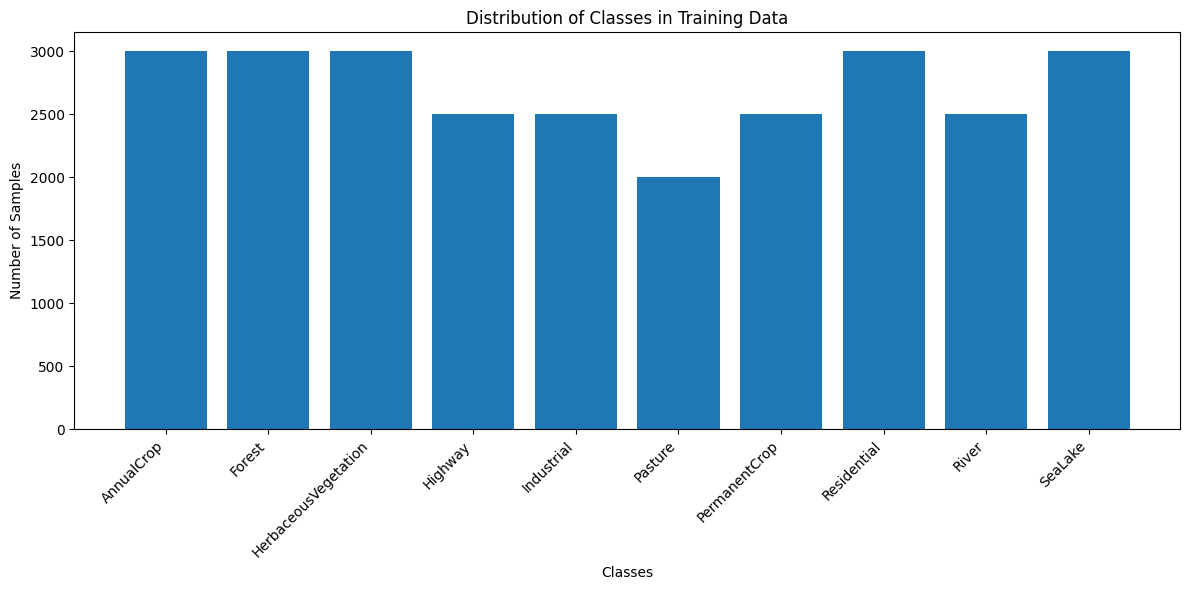

In [62]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]
counts = [label_counts.get(i, 0) for i in range(NUM_CLASSES)]

plt.bar(class_names, counts)
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04716981132075472..1.276661514683153].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34065934065934067..1.8273211117681856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34065934065934067..1.8273211117681856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33509449298923005..1.8242811501597445].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061245365042833365..1.2820094601206984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10707160274883619..2.8543632567849695].
Clipping input d

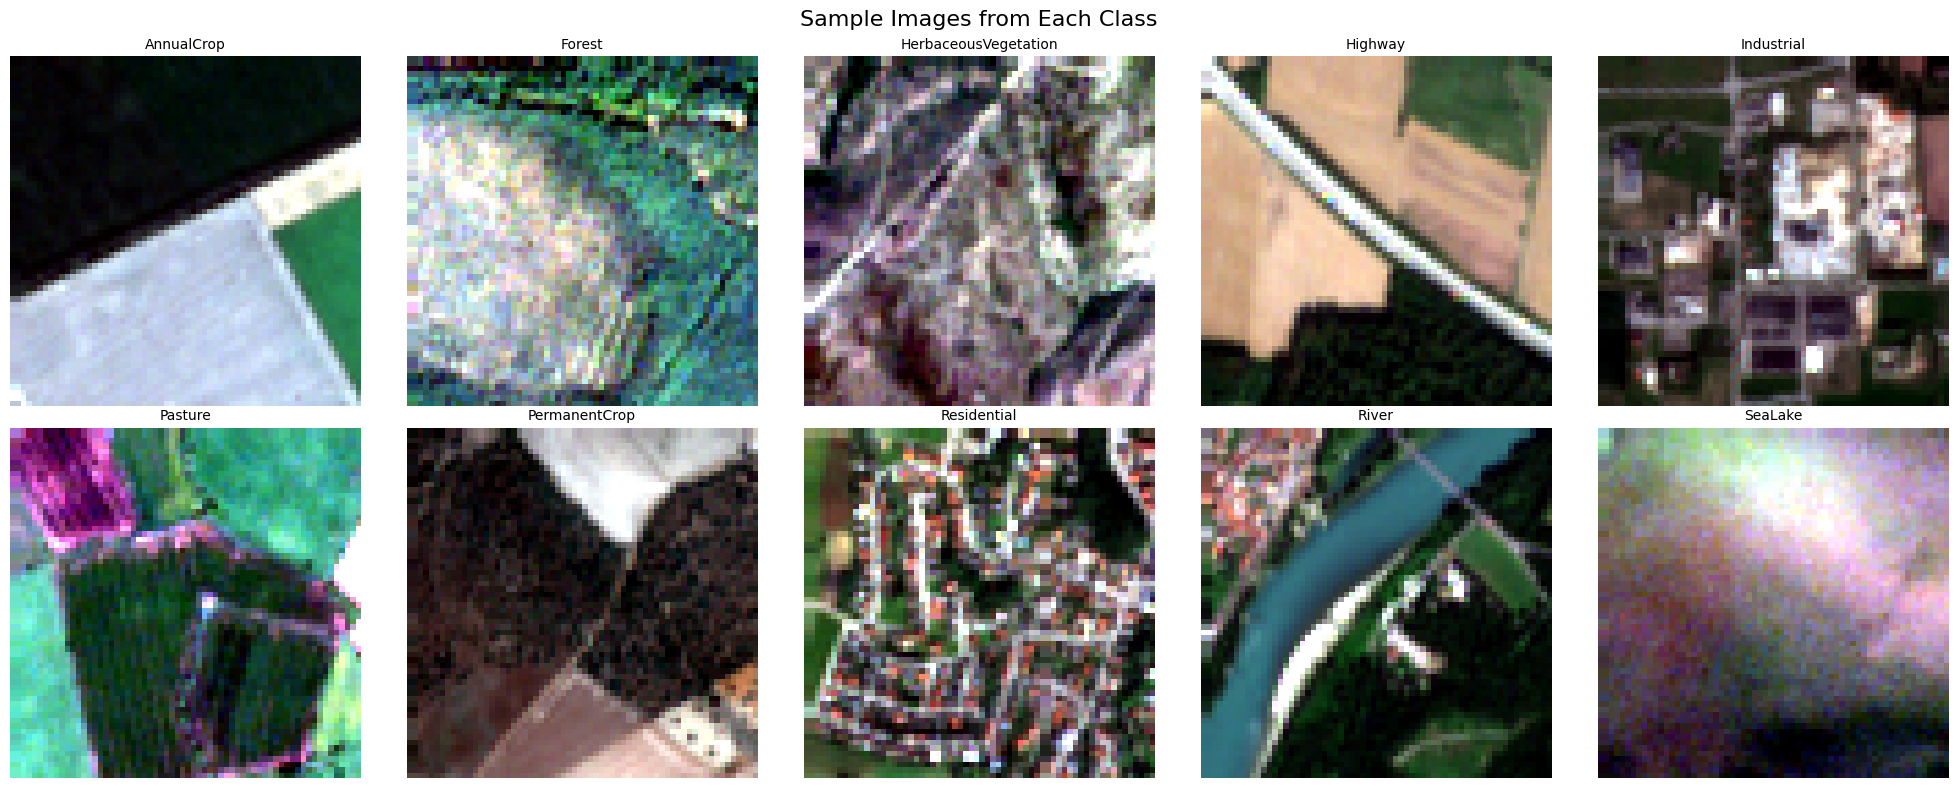

In [63]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, class_name in enumerate(CLASSES):
    # Find a sample from this class
    class_samples = [s for s in train_samples if class_name in s]
    if class_samples:
        sample_path = class_samples[0]
        
        # Load and display
        with rio.open(sample_path, "r") as f:
            img = f.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
            img = reshape_as_image(img)
        
        normalized_img = normalize_for_display(img)
        rgb_img = normalized_img[:, :, [3, 2, 1]]
        
        axes[i].imshow(rgb_img)
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Train/Validation Split

In [64]:
# Split training data into train and validation sets
train_paths, val_paths, train_labels_split, val_labels_split = train_test_split(
    train_samples, train_labels, 
    test_size=CONFIG['validation_split'], 
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Create datasets
train_dataset = EuroSATDataset(train_paths, train_labels_split, transform=train_transforms)
val_dataset = EuroSATDataset(val_paths, val_labels_split, transform=val_transforms)
test_dataset = EuroSATDataset(test_samples, transform=val_transforms, is_test=True)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=CONFIG['num_workers']
    )
val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=CONFIG['num_workers']
    )
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=CONFIG['num_workers']
    )

Training samples: 21600
Validation samples: 5400


## 7. Model Architecture

In [65]:
class EuroSATClassifier(nn.Module):
    """
    Improved CNN model for EuroSAT classification optimized for multi-spectral data.
    
    Architecture features:
    - Deeper network with residual connections
    - Appropriate receptive field for 64x64 images
    - Batch normalization for training stability
    - Dropout for regularization
    - Global average pooling to reduce parameters
    """
    
    def __init__(self, num_classes=NUM_CLASSES, input_channels=13):
        super(EuroSATClassifier, self).__init__()
        
        # Initial convolution to process multi-spectral input
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Feature extraction blocks
        self.features = nn.Sequential(
            # Block 1: 64x64 -> 32x32
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            # Block 2: 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            
            # Block 3: 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 4: 8x8 -> 4x4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize model weights using He initialization for ReLU networks."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Process multi-spectral input
        x = self.initial_conv(x)
        
        # Extract features
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classify
        x = self.classifier(x)
        
        return x

# Initialize model
model = EuroSATClassifier(num_classes=NUM_CLASSES)
model = model.to(CONFIG['device'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 4,897,546
Trainable parameters: 4,897,546


## 8. Training Setup

In [66]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)

# Add learning rate scheduling for better convergence (remove unsupported 'verbose' argument)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Monitor validation accuracy
    factor=0.5, 
    patience=5, 
    min_lr=1e-7
    # verbose=True  # Removed, not supported in some PyTorch versions
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

## 9. Training and Validation Functions

In [67]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## 10. Training Loop

In [68]:
# Implement training loop with early stopping
print("Starting training...")
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Update learning rate scheduler
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, 'best_model.pth')
        print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {patience_counter} epochs without improvement")
        break
    
    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current learning rate: {current_lr:.2e}")

print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/1
--------------------------------------------------


Training:   0%|          | 0/675 [00:00<?, ?it/s]

Validation:   0%|          | 0/169 [00:00<?, ?it/s]

Train Loss: 1.6100 | Train Acc: 35.48%
Val Loss: 1.1262 | Val Acc: 54.20%
New best model saved with validation accuracy: 54.20%
Current learning rate: 1.00e-03

Training completed. Best validation accuracy: 54.20%


## 11. Training Visualization

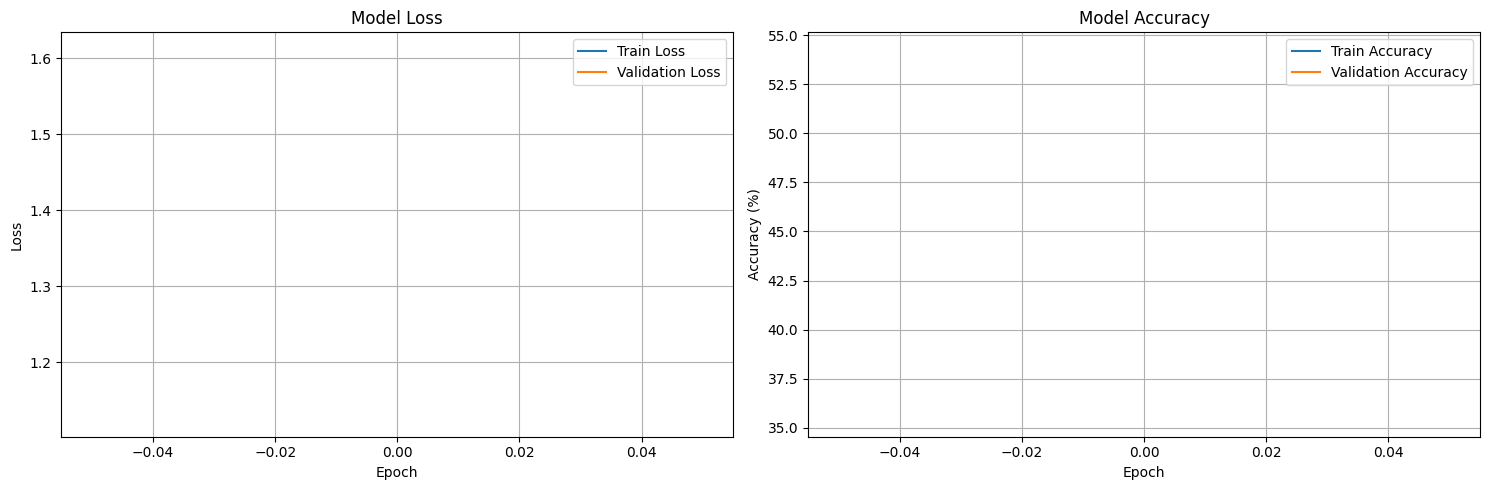

In [69]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 12. Model Evaluation

In [70]:
# Load best model for evaluation
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['best_val_acc']:.2f}%")

# Get predictions on validation set
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for data, target in tqdm(val_loader, desc='Getting validation predictions'):
        data, target = data.to(CONFIG['device']), target.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(target.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=CLASSES))

Loaded best model from epoch 0 with validation accuracy: 54.20%


Getting validation predictions:   0%|          | 0/169 [00:00<?, ?it/s]

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.62      0.87      0.73       600
              Forest       0.97      0.25      0.40       600
HerbaceousVegetation       0.28      0.25      0.27       600
             Highway       0.00      0.00      0.00       500
          Industrial       0.46      0.48      0.47       500
             Pasture       0.00      0.00      0.00       400
       PermanentCrop       0.26      0.60      0.37       500
         Residential       0.53      0.99      0.69       600
               River       0.91      0.76      0.82       500
             SeaLake       0.87      0.98      0.93       600

            accuracy                           0.54      5400
           macro avg       0.49      0.52      0.47      5400
        weighted avg       0.52      0.54      0.49      5400



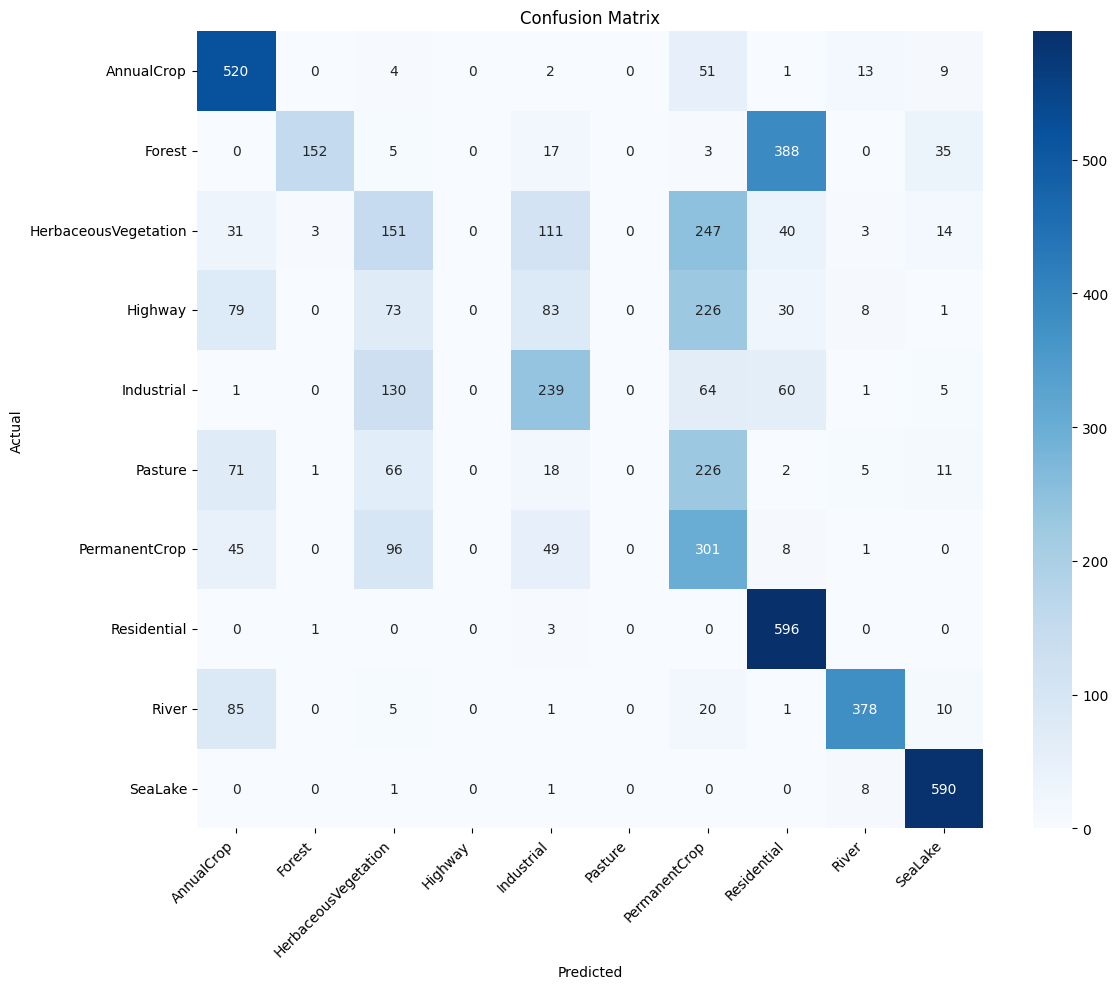

In [71]:
# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 13. Domain Shift Analysis

In [72]:
# TODO: Analyze domain shift between training and test data
# This is crucial for this challenge as mentioned in the notebook

def analyze_domain_shift():
    """
    Analyze potential domain shift between training and test data.
    
    TODO: Implement analysis techniques:
    - Statistical comparison of band values
    - Distribution comparison (histograms, KL divergence)
    - Principal Component Analysis (PCA)
    - Feature visualization with t-SNE or UMAP
    """
    
    # Sample some training and test data for comparison
    sample_train_data = []
    sample_test_data = []
    
    # Get training samples
    for i in range(min(100, len(train_samples))):
        with rio.open(train_samples[i], "r") as f:
            img = f.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
            img = reshape_as_image(img)
            sample_train_data.append(img.flatten())
    
    # Get test samples
    for i in range(min(100, len(test_samples))):
        img = np.load(test_samples[i])
        sample_test_data.append(img.flatten())
    
    sample_train_data = np.array(sample_train_data)
    sample_test_data = np.array(sample_test_data)
    
    # Compare statistics
    print("Training data statistics (mean, std):")
    print(f"Mean: {sample_train_data.mean():.4f}, Std: {sample_train_data.std():.4f}")
    
    print("Test data statistics (mean, std):")
    print(f"Mean: {sample_test_data.mean():.4f}, Std: {sample_test_data.std():.4f}")
    
    # TODO: Add more sophisticated analysis
    
analyze_domain_shift()

Training data statistics (mean, std):
Mean: 1893.4361, Std: 1184.0058
Test data statistics (mean, std):
Mean: nan, Std: nan


## 14. Domain Adaptation Techniques

In [73]:
# TODO: Implement domain adaptation techniques to address domain shift
# Possible approaches:
# 1. Test Time Adaptation (TTA)
# 2. Domain Adversarial Training
# 3. Self-training/Pseudo-labeling on test data
# 4. Statistical normalization alignment
# 5. Fine-tuning on a subset of test data (if allowed)

def apply_test_time_adaptation(model, test_loader):
    """
    Apply Test Time Adaptation techniques.
    
    TODO: Implement TTA strategies:
    - Entropy minimization
    - Batch normalization adaptation
    - Self-supervised objectives
    """
    pass

def normalize_test_data_with_train_stats(test_data, train_stats):
    """
    Normalize test data using training data statistics.
    
    TODO: Implement proper normalization alignment
    """
    pass

# Placeholder for domain adaptation implementation
print("TODO: Implement domain adaptation techniques")

TODO: Implement domain adaptation techniques


## 15. Test Set Predictions

In [74]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_filenames = []

with torch.no_grad():
    for data, filenames in tqdm(test_loader, desc='Generating test predictions'):
        data = data.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_filenames.extend(filenames)

# Convert predictions to class names
test_class_predictions = [IDX_TO_CLASS[pred] for pred in test_predictions]

print(f"Generated {len(test_predictions)} predictions")
print("Sample predictions:", test_class_predictions[:10])

Generating test predictions: 0it [00:00, ?it/s]

Generated 0 predictions
Sample predictions: []


In [75]:
# Create submission file
submission_df = pd.DataFrame({
    'filename': [os.path.basename(f) for f in test_filenames],
    'predicted_class': test_class_predictions
})

submission_df = submission_df.sort_values('filename').reset_index(drop=True)
submission_df.to_csv('predictions.csv', index=False)

print("Submission file created: predictions.csv")
print(submission_df.head(10))

Submission file created: predictions.csv
Empty DataFrame
Columns: [filename, predicted_class]
Index: []


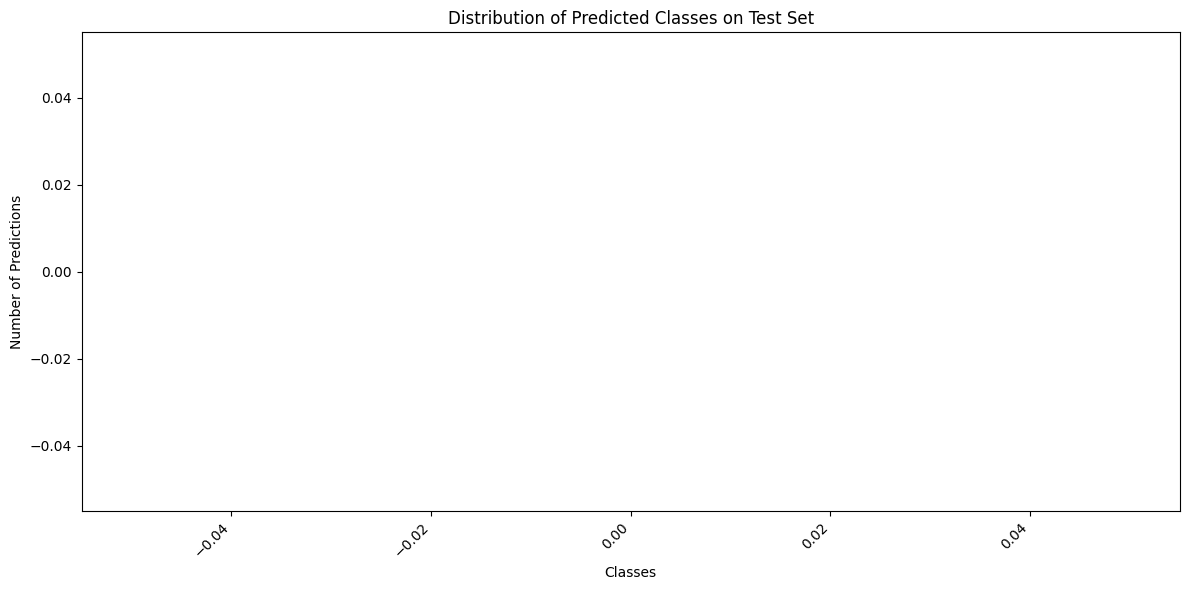

Test set prediction distribution:


In [76]:
# Analyze test predictions distribution
prediction_counts = pd.Series(test_class_predictions).value_counts()

plt.figure(figsize=(12, 6))
plt.bar(prediction_counts.index, prediction_counts.values)
plt.title('Distribution of Predicted Classes on Test Set')
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Test set prediction distribution:")
for class_name, count in prediction_counts.items():
    print(f"  {class_name}: {count}")

## 16. Model Interpretation and Analysis

In [77]:
# TODO: Implement model interpretation techniques
# - Gradient-based attribution methods
# - Occlusion analysis
# - Feature visualization
# - Band importance analysis for multi-spectral data

def analyze_band_importance():
    """Analyze which spectral bands are most important for classification."""
    # TODO: Implement band importance analysis
    pass

def visualize_model_attention():
    """Visualize what the model is focusing on."""
    # TODO: Implement attention visualization
    pass

print("TODO: Implement model interpretation and analysis")

TODO: Implement model interpretation and analysis


## 17. Error Analysis

In [78]:
# TODO: Perform detailed error analysis
# - Identify most confused classes
# - Analyze failure cases
# - Visualize misclassified samples

def analyze_misclassified_samples():
    """Analyze samples that were misclassified."""
    # TODO: Implement error analysis
    pass

def analyze_class_confusion():
    """Analyze which classes are most often confused."""
    # TODO: Implement class confusion analysis
    pass

print("TODO: Implement error analysis")

TODO: Implement error analysis


## 18. Model Improvements

In [79]:
# TODO: Ideas for model improvements:
# 1. Advanced architectures (ResNet, EfficientNet, Vision Transformers)
# 2. Multi-scale feature extraction
# 3. Attention mechanisms
# 4. Ensemble methods
# 5. Advanced data augmentation
# 6. Transfer learning from pre-trained models
# 7. Multi-task learning (e.g., NDVI regression as auxiliary task)
# 8. Advanced regularization techniques

print("TODO: Implement model improvements")
print("Consider:")
print("- Advanced CNN architectures (ResNet, EfficientNet)")
print("- Vision Transformers")
print("- Ensemble methods")
print("- Advanced data augmentation")
print("- Transfer learning")
print("- Multi-task learning")

TODO: Implement model improvements
Consider:
- Advanced CNN architectures (ResNet, EfficientNet)
- Vision Transformers
- Ensemble methods
- Advanced data augmentation
- Transfer learning
- Multi-task learning


## 19. Final Evaluation and Summary

In [80]:
# Summary of results
print("="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Total Training Samples: {len(train_paths):,}")
print(f"Total Validation Samples: {len(val_paths):,}")
print(f"Total Test Samples: {len(test_samples):,}")
print(f"Model Parameters: {trainable_params:,}")
print(f"Training Epochs: {len(history['train_loss'])}")

# TODO: Add more comprehensive evaluation metrics
# - Per-class accuracy
# - F1-scores
# - Model confidence analysis
# - Uncertainty quantification

print("\nTODO: Complete implementation of all sections marked with TODO")
print("Focus areas for improvement:")
print("1. Implement proper data normalization")
print("2. Design better model architecture")  
print("3. Add data augmentation techniques")
print("4. Address domain shift between train and test data")
print("5. Implement domain adaptation methods")
print("6. Add model interpretation and error analysis")
print("7. Experiment with advanced techniques")

FINAL RESULTS SUMMARY
Best Validation Accuracy: 54.20%
Total Training Samples: 21,600
Total Validation Samples: 5,400
Total Test Samples: 0
Model Parameters: 4,897,546
Training Epochs: 1

TODO: Complete implementation of all sections marked with TODO
Focus areas for improvement:
1. Implement proper data normalization
2. Design better model architecture
3. Add data augmentation techniques
4. Address domain shift between train and test data
5. Implement domain adaptation methods
6. Add model interpretation and error analysis
7. Experiment with advanced techniques
